## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [354]:
# Importar bibliotecas necessárias
import numpy as np
import random
import matplotlib.pyplot as plt  # Corrigido plt00 para plt
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor, LinearRegression  # Unificado as importações do sklearn.linear_model
from sklearn.model_selection import GridSearchCV, train_test_split  # Unificado imports de model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust  # statsmodels não conflita com sklearn, então permanece
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedShuffleSplit

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import BatchNormalization





    


#### Step 1.5 − Picture visulazer

In [355]:
# Função para visualizar as imagens
def img_view (dataset, labels=None, num_imgs=5):
    """
    Função que visualiza um número especificado de imagens.
    
    Parâmetros:
    - dataset: Conjunto de imagens a visualizar.
    - labels: (Opcional) Rótulos das imagens, se disponíveis.
    - num_imgs: Número de imagens a visualizar.
    """
    # Verificar quantas imagens existem no dataset
    num_imgs = min(num_imgs, len(dataset))  # Garante que não tentas visualizar mais imagens do que as disponíveis

    # Criar a figura para visualização
    plt.figure(figsize=(10, 10))
    
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i+1)
        plt.imshow(dataset[i], cmap='gray')  # Usar 'gray' para imagens em escala de cinza
        plt.axis('off')
        
        if labels is not None:
            plt.title(f"Label: {labels[i]}")

    plt.show()

#### Step 2 − Load the dataset

X_train shape antes do reshape: (2783, 2304)
X_train shape depois do reshape: (2783, 48, 48)


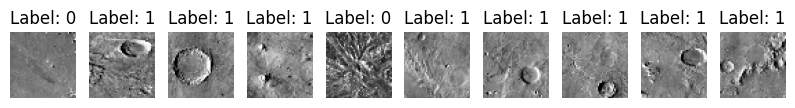

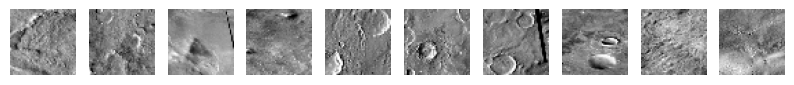

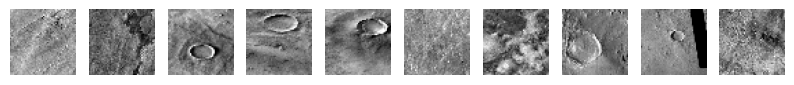

In [356]:
# Carregar os dados
X_test = np.load('Xtest1.npy')
X_train = np.load('Xtrain1.npy')
Y_train = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

# Verificar as dimensões dos datasets antes do reshape
print(f"X_train shape antes do reshape: {X_train.shape}")

# Reformatar as imagens para o formato correto (48, 48)
X_train = X_train.reshape(-1, 48, 48)
X_test = X_test.reshape(-1, 48, 48)
X_train_extra = X_train_extra.reshape(-1, 48, 48)

print(f"X_train shape depois do reshape: {X_train.shape}")
#############################################3
# Variável para controlar quantas imagens queres visualizar
num_imagens = 10  # Podes alterar este número para visualizar mais ou menos imagens
#######################################3


# Visualizar imagens de treino com rótulos
img_view(X_train, Y_train, num_imgs=num_imagens)

# Visualizar imagens de teste (sem rótulos)
img_view(X_test, num_imgs=num_imagens)

# Visualizar imagens do dataset extra (sem rótulos)
img_view(X_train_extra, num_imgs=num_imagens)


#### Step 2.5 - processamento

In [357]:
# 2. Preprocessamento: Reshape e Normalização
# Ajustar a forma das imagens para (48, 48, 1) para incluir o canal de cor (grayscale)
# A CNN espera 4 dimensões: (número de amostras, altura, largura, número de canais)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Normalizar os valores dos píxeis para estar entre 0 e 1, dividindo por 255
# Isto ajuda o modelo a convergir melhor durante o treino
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verificar novamente a forma após o reshape
print(f"Forma de X_train depois do reshape: {X_train.shape}")
print(f"Forma de X_test depois do reshape: {X_test.shape}")

# Dividir o conjunto de treino em treino e validação (20% dos dados para validação)
# O conjunto de validação é usado para verificar a performance do modelo durante o treino
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=35)


Forma de X_train depois do reshape: (2783, 48, 48, 1)
Forma de X_test depois do reshape: (696, 48, 48, 1)


#### Step 2.5 - Balancing the dataset

Forma de X_train depois do reshape: (2226, 48, 48, 1)
Forma de X_test depois do reshape: (2796, 48, 48, 1)


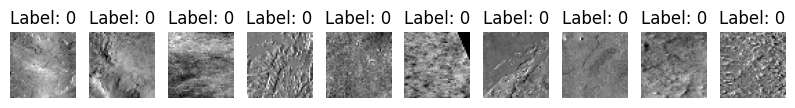

Class distribution in the resampled training set: {0: 1398, 1: 1398}


In [358]:
#RANDOM OVERSAMPLER (OVERSAMPLES MINORITY CLASS)

ros = RandomOverSampler(random_state=35)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), Y_train)

# Reshape the resampled data back to image format
X_train_resampled = X_train_resampled.reshape(-1, 48, 48, 1)

print(f"Forma de X_train depois do reshape: {X_train.shape}")
print(f"Forma de X_test depois do reshape: {X_train_resampled.shape}")
num_imgs_to_view = 10
img_view(X_train_resampled[-num_imgs_to_view:], Y_train_resampled[-num_imgs_to_view:], num_imgs=num_imgs_to_view)

# Check class distribution in the resampled training set
unique, counts = np.unique(Y_train_resampled, return_counts=True)
print(f"Class distribution in the resampled training set: {dict(zip(unique, counts))}")



#### Step 3 −Definir a arquitetura da cnn 

In [359]:
from tensorflow.keras import regularizers

def create_cnn_model(input_shape):
    # L2 regularization factor
    l2_lambda = 0.01  # Can adjust between 0.0001 and 0.01 based on performance

    # Define the CNN
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces to 24x24
    # First convolutional layer:
    # - 8 filters of size 3x3
    # - ReLU activation
    # - L2 regularization
    # - Input shape of 48x48 grayscale image (1 channel)
    model.add(Conv2D(64, (3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces to 24x24

    # Second convolutional layer:
    # - 16 filters of size 3x3
    # - ReLU activation
    # - L2 regularization

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces to 24x24



    # Flatten: Converts 3D feature maps into a 1D vector
    model.add(Flatten())

    # Fully connected layer:
    # - 32 neurons (reduced from 64)
    # - ReLU activation
    # - L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Dropout: Randomly drop 30% of neurons during training to prevent overfitting
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    


    # Output layer:
    # - 1 neuron for binary classification
    # - Sigmoid activation function for binary output (crater or not)
    
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model





####Step 3 - Compilar o modelo

In [360]:
# 4. Compilar o modelo
# - Otimizador 'adam': uma versão otimizada do gradiente descendente
# - Função de perda 'binary_crossentropy': apropriada para problemas de classificação binária
# - Métrica 'accuracy': avalia a percentagem de previsões corretas
# Monitor 'val_loss', stop training if no improvement for 3 epochs
# Initialize the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_orig=create_cnn_model(X_train.shape[1:])
history_original = model_orig.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/200
70/70 [==============================] - 3s 27ms/step - loss: 1.7248 - accuracy: 0.6276 - val_loss: 0.8542 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 2/200
70/70 [==============================] - 2s 24ms/step - loss: 0.7018 - accuracy: 0.7790 - val_loss: 0.5627 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/200
70/70 [==============================] - 2s 24ms/step - loss: 0.5402 - accuracy: 0.8203 - val_loss: 0.5082 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 4/200
70/70 [==============================] - 2s 24ms/step - loss: 0.4841 - accuracy: 0.8217 - val_loss: 0.4734 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 5/200
70/70 [==============================] - 2s 24ms/step - loss: 0.4220 - accuracy: 0.8486 - val_loss: 0.4410 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 6/200
70/70 [==============================] - 2s 23ms/step - loss: 0.4058 - accuracy: 0.8580 - val_loss: 0.4059 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 7/200
70/70 [==============================] - 2s 22ms/step - lo

#### Step 4.1 - Treinar o modelo 

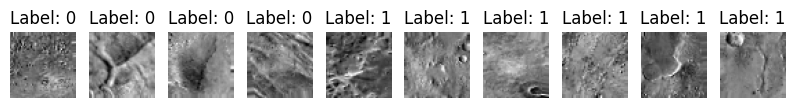

Epoch 1/200


2024-10-17 23:10:54.185467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


88/88 [==============================] - 4s 27ms/step - loss: 1.5600 - accuracy: 0.5708 - val_loss: 0.8164 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 2/200
88/88 [==============================] - 2s 25ms/step - loss: 0.6524 - accuracy: 0.7622 - val_loss: 0.5018 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 3/200
88/88 [==============================] - 2s 25ms/step - loss: 0.4956 - accuracy: 0.8087 - val_loss: 0.4525 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 4/200
88/88 [==============================] - 2s 25ms/step - loss: 0.4691 - accuracy: 0.8083 - val_loss: 0.5668 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 5/200
88/88 [==============================] - 2s 23ms/step - loss: 0.4494 - accuracy: 0.8201 - val_loss: 0.4405 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 6/200
88/88 [==============================] - 2s 22ms/step - loss: 0.4427 - accuracy: 0.8294 - val_loss: 0.4456 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 7/200
88/88 [==============================] - 2s 21ms/step - loss: 0.4310 -

In [361]:
# 5. Treinar o modelo
# - Usamos o método .fit() para treinar o modelo nos dados de treino
# - Validação é monitorizada ao usar o conjunto de validação
# - O treino ocorre por 15 épocas com um batch size de 32 (pode-se ajustar esses valores)

# Create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,              # Reduce rotation
    width_shift_range=0.05,   # Reduce the horizontal shift to 5% of the width
    height_shift_range=0.05,        # Slightly reduce height shift

)


#print(f"Min pixel value: {X_train_resampled.min()}")
#print(f"Max pixel value: {X_train_resampled.max()}")

#img_view(X_train_resampled, num_imgs=10)
# Generate and visualize 10 augmented images
#sample_image = X_train_resampled[0].reshape(48, 48, 1)  # Use a sample image from X_train_resampled
#sample_image = sample_image.reshape((1,) + sample_image.shape)  # Reshape for ImageDataGenerator

#gen = datagen.flow(sample_image, batch_size=1)  # Initialize the generator

#augmented_images = [datagen.flow(X_train_resampled.reshape(-1, 48, 48, 1), batch_size=1).next()[0].reshape(48, 48) for _ in range(10)]

# Visualize the generated images
#img_view(augmented_images, num_imgs=10)

# Function to visualize augmented images
def visualize_augmented_images(datagen, original_images, labels, num_images=10, batch_size=5):
    """
    Visualizes augmented images generated by the datagen.
    
    Parameters:
    - datagen: ImageDataGenerator instance.
    - original_images: Original images to generate augmentations from.
    - labels: Corresponding labels for the original images.
    - num_images: Number of augmented images to visualize.
    - batch_size: Number of images per batch.
    """
    # Create a batch of augmented images
    for batch in datagen.flow(X_train_resampled.reshape(-1, 48, 48, 1), Y_train_resampled, batch_size=num_images):
        batch_images = batch[0]  # Get the images from the batch
        batch_labels = batch[1]  # Get the labels from the batch
        break  # We only need one batch for visualization
    
    # Use the img_view function to visualize the images
    img_view(batch_images.reshape(-1, 48, 48), batch_labels, num_imgs=num_images)


    

# Visualize some augmented images
visualize_augmented_images(datagen, X_train_resampled, Y_train_resampled, num_images=10, batch_size=5)



callbacks=[early_stopping, reduce_lr]







model_resampled=create_cnn_model(X_train_resampled.shape[1:])

history_resampled = model_resampled.fit(
    datagen.flow(X_train_resampled, Y_train_resampled, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=200,
    callbacks=callbacks
)

#history_resampled = model_resampled.fit(X_train_resampled, Y_train_resampled, epochs=15, batch_size=32, validation_data=(X_val, Y_val))

#history_resampled = model_resampled.fit(X_train_resampled, Y_train_resampled, epochs=15, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# O objeto "history" guarda a precisão e a perda de cada época, útil para gráficos


#### Step 4 - With regularization


In [362]:
# 6. Avaliar o modelo no conjunto de teste
# - Usamos o método .evaluate() para testar o modelo nos dados não vistos
# - Ele retorna a perda e a métrica (neste caso, accuracy)
#test_loss, test_acc = model.evaluate(X_test, verbose=2)
#print(f"Test accuracy: {test_acc}")


#### Step 7 − View model


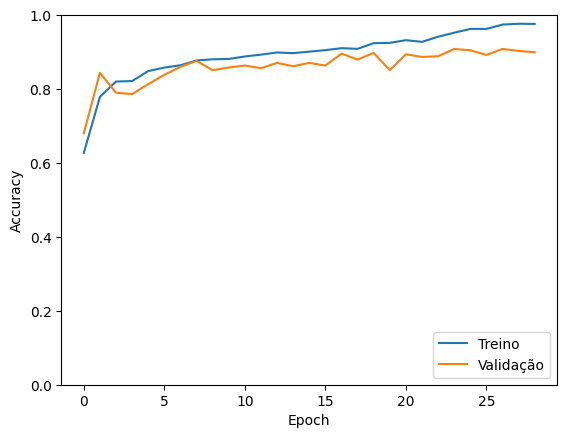

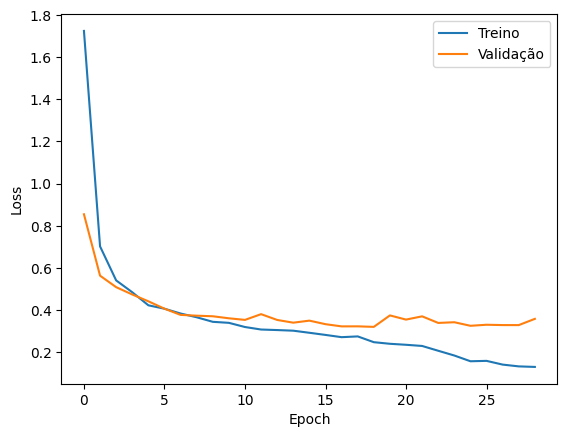

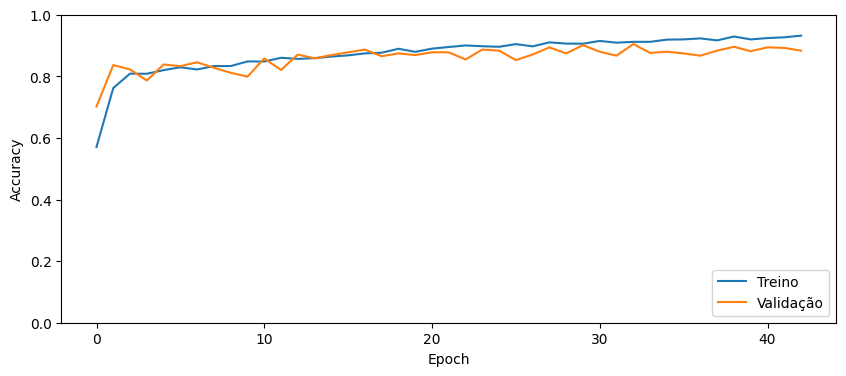

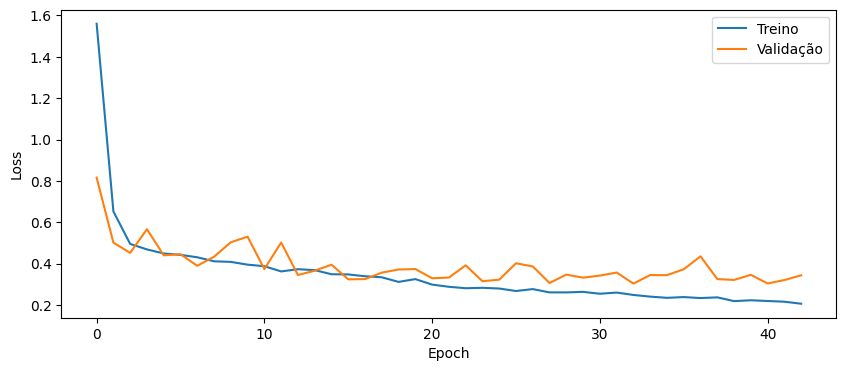

In [363]:
# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.plot(history_original.history['accuracy'], label='Treino')
plt.plot(history_original.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_original.history['loss'], label='Treino')
plt.plot(history_original.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.figure(figsize=(10, 4))
plt.plot(history_resampled.history['accuracy'], label='Treino')
plt.plot(history_resampled.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 4))
# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_resampled.history['loss'], label='Treino')
plt.plot(history_resampled.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


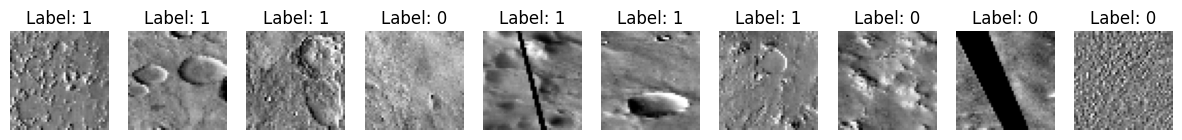

In [364]:
# Vamos mostrar as primeiras 10 imagens do conjunto de validação e seus rótulos correspondentes
# 0 - Sem cratera
# 1 - Com cratera

def visualizar_imagens_validacao(X_val, Y_val, num_imagens=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i + 1)
        plt.imshow(X_val[i].reshape(48, 48), cmap='gray')  # Exibimos a imagem em escala de cinza
        plt.title(f"Label: {Y_val[i]}")
        plt.axis('off')  # Desativa os eixos
        
    plt.show()

# Chamar a função para visualizar as primeiras 10 imagens e seus rótulos
visualizar_imagens_validacao(X_val, Y_val, num_imagens=10)


18/18 [==============================] - 0s 8ms/step
F1 Score no conjunto de validação ORIGINAL: 0.9261
F1 Score no conjunto de validação RESAMPLED: 0.9309


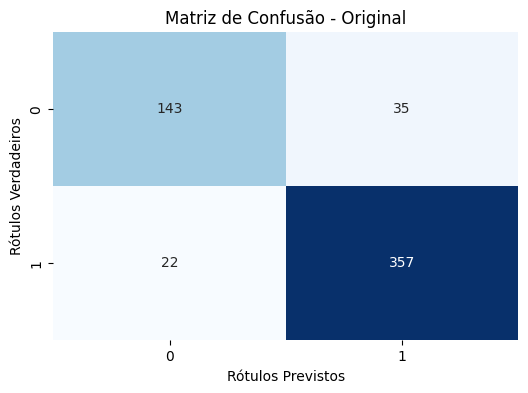

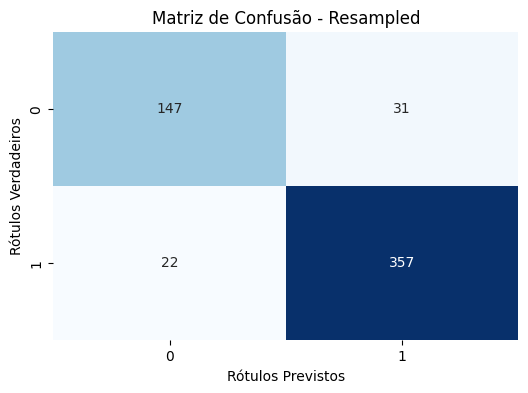

In [365]:
from sklearn.metrics import f1_score

# Fazer previsões no conjunto de validação (X_val)
# O modelo gera probabilidades, então usamos um limiar de 0.5 para classificar
Y_pred_val_orig = (model_orig.predict(X_val) > 0.5).astype("int32")
Y_pred_val_resampled = (model_resampled.predict(X_val) > 0.5).astype("int32")


# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val_orig)

print(f"F1 Score no conjunto de validação ORIGINAL: {f1:.4f}")

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val_resampled)

print(f"F1 Score no conjunto de validação RESAMPLED: {f1:.4f}")


# Função para exibir a matriz de confusão
def plot_confusion_matrix(Y_true, Y_pred, model_name="Modelo"):
    """
    Função para calcular e plotar a matriz de confusão.
    
    Parâmetros:
    - Y_true: Rótulos verdadeiros.
    - Y_pred: Rótulos previstos.
    - model_name: Nome do modelo (para o título do gráfico).
    """
    # Calcular a matriz de confusão
    cm = confusion_matrix(Y_true, Y_pred)

    # Plotar a matriz de confusão usando Seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel('Rótulos Previstos')
    plt.ylabel('Rótulos Verdadeiros')
    plt.show()



# Plotar a matriz de confusão para o modelo original
plot_confusion_matrix(Y_val, Y_pred_val_orig, model_name="Original")

# Plotar a matriz de confusão para o modelo resampled
plot_confusion_matrix(Y_val, Y_pred_val_resampled, model_name="Resampled")




#### USING EXTRA UNLABELED DATA

In [368]:
# Step 3: Combine original labeled data with pseudo-labeled data

X_train_extra = X_train_extra.reshape(-1, 48, 48, 1)

predictions = model_resampled.predict(X_train_extra)

pseudo_labels = (predictions > 0.9).astype("int32")

confident_indices = np.where(pseudo_labels == 1)[0]
X_pseudo_labeled = X_train_extra[confident_indices]
y_pseudo_labeled = pseudo_labels[confident_indices]


# Combine the pseudo-labeled data with the original labeled dataset
X_combined = np.concatenate((X_train_resampled, X_pseudo_labeled), axis=0)
y_pseudo_labeled = y_pseudo_labeled.reshape(-1)
Y_combined = np.concatenate((Y_train_resampled, y_pseudo_labeled), axis=0)


# Get prediction probabilities for X_train_extra
#Y_pred_probs_extra = model_resampled.predict(X_train_extra)

# Set a higher threshold for confident predictions (e.g., 0.9)
#high_confidence_threshold = 0.9

# Only keep the predictions where the probability is above the threshold
#high_confidence_indices = np.where((Y_pred_probs_extra > high_confidence_threshold) | 
#                                   (Y_pred_probs_extra < (1 - high_confidence_threshold)))[0]

# Filter X_train_extra and Y_pred_val_resampled for only the high-confidence examples
#X_train_extra_high_conf = X_train_extra[high_confidence_indices]
#Y_pred_val_resampled_high_conf = (Y_pred_probs_extra[high_confidence_indices] > 0.5).astype("int32").flatten()

# Ensure X_train_extra_high_conf has the shape (n_samples, 48, 48, 1)
#X_train_extra_high_conf = X_train_extra_high_conf.reshape(-1, 48, 48, 1)

# Now concatenate both datasets along the sample axis (axis=0)
#X_combined = np.concatenate([X_train_resampled, X_train_extra_high_conf], axis=0)
#Y_combined = np.concatenate([Y_train_resampled, Y_pred_val_resampled_high_conf], axis=0)

# Shuffle the combined dataset
#combined_indices = np.arange(X_combined.shape[0])
#np.random.shuffle(combined_indices)
#X_combined = X_combined[combined_indices]
#Y_combined = Y_combined[combined_indices]



#X_combined_flat = X_combined.reshape(X_combined.shape[0], -1)

#ros = RandomOverSampler(random_state=42)
#X_combined_resampled, Yfrom tensorflow.keras import regularizers


model_pseudo=create_cnn_model(X_combined.shape[1:])


history_pseudo = model_pseudo.fit(
    datagen.flow(X_combined, Y_combined, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=200,
    callbacks=callbacks
)

Y_pred_val_extra = (model_pseudo.predict(X_val) > 0.5).astype("int32")

f1 = f1_score(Y_val, Y_pred_val_extra)

print(f"F1 Score no conjunto de validação RESAMPLED: {f1:.4f}")




29/29 [==============================] - 0s 10ms/step
Epoch 1/200


2024-10-17 23:14:10.297890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


116/116 [==============================] - 4s 26ms/step - loss: 1.5440 - accuracy: 0.6573 - val_loss: 0.9982 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 2/200
116/116 [==============================] - 3s 24ms/step - loss: 0.6562 - accuracy: 0.8010 - val_loss: 0.6845 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 3/200
116/116 [==============================] - 3s 24ms/step - loss: 0.4670 - accuracy: 0.8427 - val_loss: 0.5670 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 4/200
116/116 [==============================] - 3s 23ms/step - loss: 0.4029 - accuracy: 0.8535 - val_loss: 0.5928 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 5/200
116/116 [==============================] - 3s 21ms/step - loss: 0.3722 - accuracy: 0.8622 - val_loss: 0.5234 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 6/200
116/116 [==============================] - 3s 22ms/step - loss: 0.3517 - accuracy: 0.8600 - val_loss: 0.5482 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 7/200
116/116 [==============================] - 3s 22ms/step - 

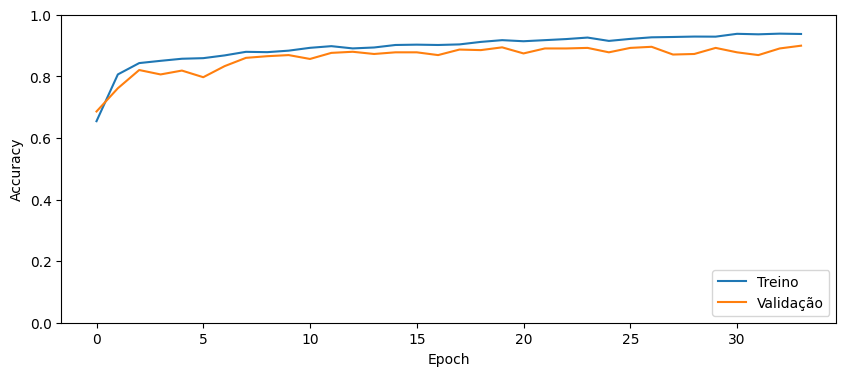

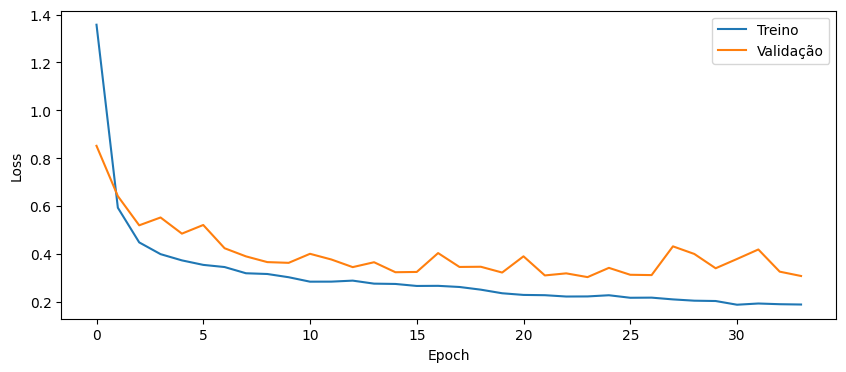

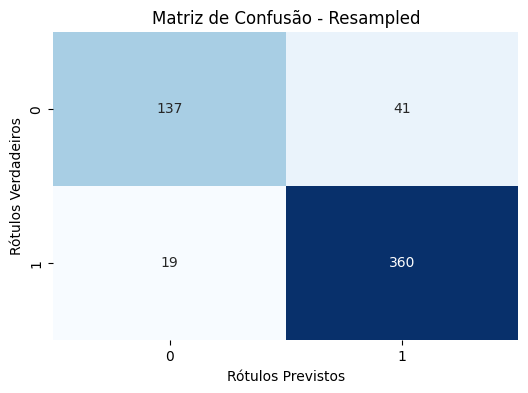

In [367]:

# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.figure(figsize=(10, 4))
plt.plot(history_pseudo.history['accuracy'], label='Treino')
plt.plot(history_pseudo.history['val_accuracy'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 4))
# Se quiseres visualizar também a perda, podes usar:
plt.plot(history_pseudo.history['loss'], label='Treino')
plt.plot(history_pseudo.history['val_loss'], label = 'Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plotar a matriz de confusão para o modelo resampled
plot_confusion_matrix(Y_val, Y_pred_val_extra, model_name="Resampled")


In [375]:


#Y_pred = (model_pseudo.predict(X_test) > 0.5).astype("int32")

#Y_pred = Y_pred.flatten()

#print(X_test.shape)
#print(Y_pred.shape)
#print(Y_pred[:-10])

#np.save('ytest_pred.npy', Y_pred)





22/22 [==============================] - 0s 8ms/step
(696, 48, 48, 1)
(696,)
[0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1
 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1
 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0
 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0
 1 1 0 1 1 0 1 1 1 1 1 